## Happiness vs Traffic Deaths (2019)

#### Data sources:
- https://apps.who.int/gho/data/view.main.51310?lang=en
- https://www.kaggle.com/datasets/jainaru/world-happiness-report-2024-yearly-updated/data

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
import numpy as np
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [4]:
year = "2019"

### Data processing

#### Traffic Deaths

In [5]:
traffic_df = pd.read_csv('data/traffic_deaths.csv')

In [6]:
traffic_df.columns

Index(['Unnamed: 0', 'Unnamed: 1', 'Estimated number of road traffic deaths',
       'Estimated number of road traffic deaths.1',
       'Estimated number of road traffic deaths.2',
       'Estimated road traffic death rate (per 100 000 population)',
       'Estimated road traffic death rate (per 100 000 population).1',
       'Estimated road traffic death rate (per 100 000 population).2'],
      dtype='object')

We can ignore the sum of traffic deaths, as the death rate per 100 000 people is more useful to find the ratio without having to consider the size of the country.

In [7]:
# Rename the columns to more meaningful names
traffic_df.columns = [
    'Country', 'Year', 'Estimated_deaths_both_sexes', 'Estimated_deaths_male', 'Estimated_deaths_female',
    'DeathRate', 'DeathRateMale', 'DeathRateFemale'
]

In [8]:
# Drop columns we don't need and the first row which contains duplicate column names
traffic_df = traffic_df.drop(columns=["Estimated_deaths_both_sexes", "Estimated_deaths_male", "Estimated_deaths_female"])
traffic_df = traffic_df.drop(index=0)


In [9]:
traffic_df.head()

,Country,Year,DeathRate,DeathRateMale,DeathRateFemale
1,Afghanistan,2019,15.9 [13.7-18.0],24.8 [21.5-28.2],6.4 [5.5-7.2]
2,Afghanistan,2018,14.2 [12.3-16.2],22.7 [19.6-25.8],5.3 [4.6-6.0]
3,Afghanistan,2017,15.1 [13.1-17.2],23.8 [20.5-27.0],6.0 [5.2-6.8]
4,Afghanistan,2016,14.8 [12.8-16.9],23.3 [20.1-26.6],5.8 [5.0-6.6]
5,Afghanistan,2015,14.4 [12.3-16.4],22.5 [19.3-25.7],5.7 [4.9-6.6]


In [10]:
# Filter the data by year, we defined the year at the top of the notebook. 
traffic_df = traffic_df[traffic_df['Year'] == year]
traffic_df.reset_index(drop=True, inplace=True)

In [11]:
traffic_df.head()

,Country,Year,DeathRate,DeathRateMale,DeathRateFemale
0,Afghanistan,2019,15.9 [13.7-18.0],24.8 [21.5-28.2],6.4 [5.5-7.2]
1,Albania,2019,11.7 [10.8-12.6],17.6 [16.3-18.9],5.5 [5.1-5.9]
2,Algeria,2019,20.9 [18.6-23.2],28.1 [25.0-31.2],13.6 [12.1-15.1]
3,Angola,2019,26.1 [19.9-32.4],34.3 [26.0-42.5],18.2 [13.8-22.5]
4,Antigua and Barbuda,2019,0.0 [0.0-0.0],0.0 [0.0-0.0],0.0 [0.0-0.0]


The data format represents an estimate along with a range, likely indicating an error margin or confidence interval. To handle this, it would make sense to slipt these columns into separate parts for the estimated value, and the lower and upper bounds of the range. However, we will just stick with the estimated value for now.

In [12]:
# Function to extract the first number (the estimate), and convert it to a float. 
def extract_first_number(value):
    if pd.isna(value):
        return None
    return float(value.split(' ')[0])

In [13]:
# Apply the function to all the columns
traffic_df['DeathRate'] = traffic_df['DeathRate'].apply(extract_first_number)
traffic_df['DeathRateMale'] = traffic_df['DeathRateMale'].apply(extract_first_number)
traffic_df['DeathRateFemale'] = traffic_df['DeathRateFemale'].apply(extract_first_number)

In [14]:
traffic_df.head()

,Country,Year,DeathRate,DeathRateMale,DeathRateFemale
0,Afghanistan,2019,15.9,24.8,6.4
1,Albania,2019,11.7,17.6,5.5
2,Algeria,2019,20.9,28.1,13.6
3,Angola,2019,26.1,34.3,18.2
4,Antigua and Barbuda,2019,0.0,0.0,0.0


In [15]:
traffic_df.duplicated(subset=['Country']).sum()

0

In [16]:
traffic_df.isna().sum()

Country            0
Year               0
DeathRate          0
DeathRateMale      0
DeathRateFemale    0
dtype: int64

In [17]:
traffic_df.shape

(183, 5)

The data contains no NaN-value and no duplicates, and lists a total of 183 countries. 

In [18]:
traffic_df.describe()

,DeathRate,DeathRateMale,DeathRateFemale
count,183.000000,183.00000,183.000000
mean,17.085792,25.47377,8.704372
std,10.811355,16.27916,6.222538
min,0.000000,0.00000,0.000000
25%,8.050000,12.55000,3.550000
50%,15.300000,23.40000,6.800000
75%,25.650000,36.80000,12.900000
max,64.600000,110.60000,24.900000


#### World Happiness Report

In [19]:
happy_df = pd.read_csv('data/world_happiness_report.csv', encoding='latin')

In [20]:
happy_df.head()

,Country name,year,Life Ladder,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Positive affect,Negative affect
0,Afghanistan,2008,3.724,7.350,0.451,50.5,0.718,0.164,0.882,0.414,0.258
1,Afghanistan,2009,4.402,7.509,0.552,50.8,0.679,0.187,0.850,0.481,0.237
2,Afghanistan,2010,4.758,7.614,0.539,51.1,0.600,0.118,0.707,0.517,0.275
3,Afghanistan,2011,3.832,7.581,0.521,51.4,0.496,0.160,0.731,0.480,0.267
4,Afghanistan,2012,3.783,7.661,0.521,51.7,0.531,0.234,0.776,0.614,0.268


The data contains a lot of different factors, but to simplify it we will only keep a few of them. 

- Life Ladder: The happiness score where the best possible life is 10, and the worst is 0
- Log GDP per capita: The natural logarithm of the country's GDP per capita, adjusted for purchasing power parity (PPP) to account for differences in the cost of living between countries.
- Social Support: Binary responses (0 or 1 representing No or Yes) if the person has relatives or friends to count on in times of trouble.
- Freedom to make life choices: Binary response (0 or 1 representing No or Yes) if the person feels free to make decisions about their own life.

We start by doing the same steps as above, renaming columns to more sensible names, filtering the data by the relevant year and dropping columns we won't be using in this analysis. 

In [21]:
happy_df.columns

Index(['Country name', 'year', 'Life Ladder', 'Log GDP per capita',
       'Social support', 'Healthy life expectancy at birth',
       'Freedom to make life choices', 'Generosity',
       'Perceptions of corruption', 'Positive affect', 'Negative affect'],
      dtype='object')

In [22]:
# Drop
happy_df = happy_df.drop(columns=["Healthy life expectancy at birth", "Generosity", "Perceptions of corruption", "Positive affect", "Negative affect"])

In [23]:
# Rename
happy_df.columns = [
    'Country', 'Year', 'Score', 'GDP', 'Support', 'Freedom']

In [24]:
happy_df.dtypes

Country     object
Year         int64
Score      float64
GDP        float64
Support    float64
Freedom    float64
dtype: object

In [25]:
# Year is a integer in this case, so we convert it to a string to match the traffic_df
happy_df["Year"] = happy_df["Year"].astype(str) 
happy_df = happy_df[happy_df['Year'] == year]

happy_df.reset_index(drop=True, inplace=True)

In [26]:
happy_df.head()

,Country,Year,Score,GDP,Support,Freedom
0,Afghanistan,2019,2.375,7.640,0.420,0.394
1,Albania,2019,4.995,9.522,0.686,0.777
2,Algeria,2019,4.745,9.361,0.803,0.385
3,Argentina,2019,6.086,10.002,0.896,0.817
4,Armenia,2019,5.488,9.569,0.782,0.844


In [27]:
happy_df.describe()

,Score,GDP,Support,Freedom
count,143.000000,143.000000,143.000000,142.000000
mean,5.570965,9.454161,0.816895,0.794683
std,1.116440,1.188076,0.118165,0.117164
min,2.375000,5.527000,0.420000,0.385000
25%,4.923000,8.576000,0.759000,0.716500
50%,5.626000,9.578000,0.845000,0.817500
75%,6.290500,10.435500,0.911000,0.890000
max,7.780000,11.649000,0.982000,0.970000


In [28]:
happy_df.duplicated(subset=['Country']).sum()

0

In [29]:
happy_df.isna().sum()

Country    0
Year       0
Score      0
GDP        0
Support    0
Freedom    1
dtype: int64

There are no duplicate countries, but one country is missing the "freedom"-value. 

In [30]:
missing_values = happy_df.isna().any(axis=1)

In [31]:
print(happy_df[missing_values])

        Country  Year  Score    GDP  Support  Freedom
124  Tajikistan  2019  5.464  8.182     0.88      NaN


Tajikistan is missing the freedom value, and general knowledge of the region indicates that this is not a very free country in that sense. We could just replace the value with f.ex the mean value for the dataset, but there are a lot of outliers, and the mean value is quite high (0.79).

It will probably make more sense to replace the missing value with something that corresponds to the happiness value, so we should sort the dataframe and look at what the freedom is in countries with a similar happiness score.  

In [32]:
# Sort by score in descending order
happy_df = happy_df.sort_values(by='Score', ascending=False)

In [33]:
# Adjust the index so that it starts from 1
happy_df.reset_index(drop=True, inplace=True)
happy_df.index = happy_df.index + 1

In [34]:
happy_df.head()

,Country,Year,Score,GDP,Support,Freedom
1,Finland,2019,7.780,10.791,0.937,0.948
2,Switzerland,2019,7.694,11.155,0.949,0.913
3,Denmark,2019,7.693,10.948,0.958,0.963
4,Iceland,2019,7.533,10.943,0.982,0.959
5,Norway,2019,7.442,11.082,0.942,0.954


Now, let's find where Tajikistan is on the list, so we can find out who it's "neighbors" are. We will then look at the five countries below and above Tajikistan, and assign it the mean index value of these countries.  

In [35]:
happy_df.index[happy_df["Country"] == "Tajikistan"]

Index([78], dtype='int64')

In [36]:
happy_df.loc[73:83, "Freedom"].mean()

0.8009000000000001

After all, it turns out we were probably wrong, and that the mean value of the dataset was fairly representative. Let's fill in the freedom score, and move on to better things. 

In [37]:
happy_df.loc[78, 'Freedom'] = round(happy_df.loc[73:83, "Freedom"].mean(), 3)

In [38]:
happy_df[happy_df['Country'] == 'Tajikistan']

,Country,Year,Score,GDP,Support,Freedom
78,Tajikistan,2019,5.464,8.182,0.88,0.801


In [39]:
happy_df.shape

(143, 6)

We have no duplicate or NA values, but it seems that the happiness report only includes 143 countries, and our traffic death data has 183. We need to filter out the countries that are present in both of the dataframes. To acheive this, we will merge the two dataframes using the "Country"-column, keeping only the relevant countries. 

In [40]:
df = pd.merge(happy_df, traffic_df, on="Country")

In [41]:
df.head(1)

,Country,Year_x,Score,GDP,Support,Freedom,Year_y,DeathRate,DeathRateMale,DeathRateFemale
0,Finland,2019,7.78,10.791,0.937,0.948,2019,3.9,5.9,1.9


Now we have one big dataframe with all our data, sorted by the happiness score. Year appears twice as year_x and year_y, so let's fix that. 

In [42]:
df = df.drop(columns=["Year_y"])
df = df.rename(columns={'Year_x': 'Year'})

In [43]:
df.head()

,Country,Year,Score,GDP,Support,Freedom,DeathRate,DeathRateMale,DeathRateFemale
0,Finland,2019,7.780,10.791,0.937,0.948,3.9,5.9,1.9
1,Switzerland,2019,7.694,11.155,0.949,0.913,2.2,3.3,1.2
2,Denmark,2019,7.693,10.948,0.958,0.963,3.7,5.3,2.1
3,Iceland,2019,7.533,10.943,0.982,0.959,2.0,3.4,0.7
4,Norway,2019,7.442,11.082,0.942,0.954,2.1,3.3,1.0


Our data is clean and ready, so it's time to jump into the analysis.

## Analysis

In [44]:
df.describe()

,Score,GDP,Support,Freedom,DeathRate,DeathRateMale,DeathRateFemale
count,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000
mean,5.559105,9.450258,0.817403,0.797895,16.564516,24.913710,8.299194
std,1.144110,1.160939,0.121673,0.118652,10.691020,16.400884,5.881437
min,2.375000,7.105000,0.420000,0.385000,2.000000,3.100000,0.700000
25%,4.861000,8.563000,0.759000,0.724250,7.850000,11.875000,3.575000
50%,5.639500,9.585000,0.846500,0.820000,15.200000,23.100000,6.300000
75%,6.281250,10.400750,0.912250,0.892000,23.050000,34.975000,12.650000
max,7.780000,11.649000,0.982000,0.970000,64.600000,110.600000,24.900000


So, who is the biggest winners and losers here?

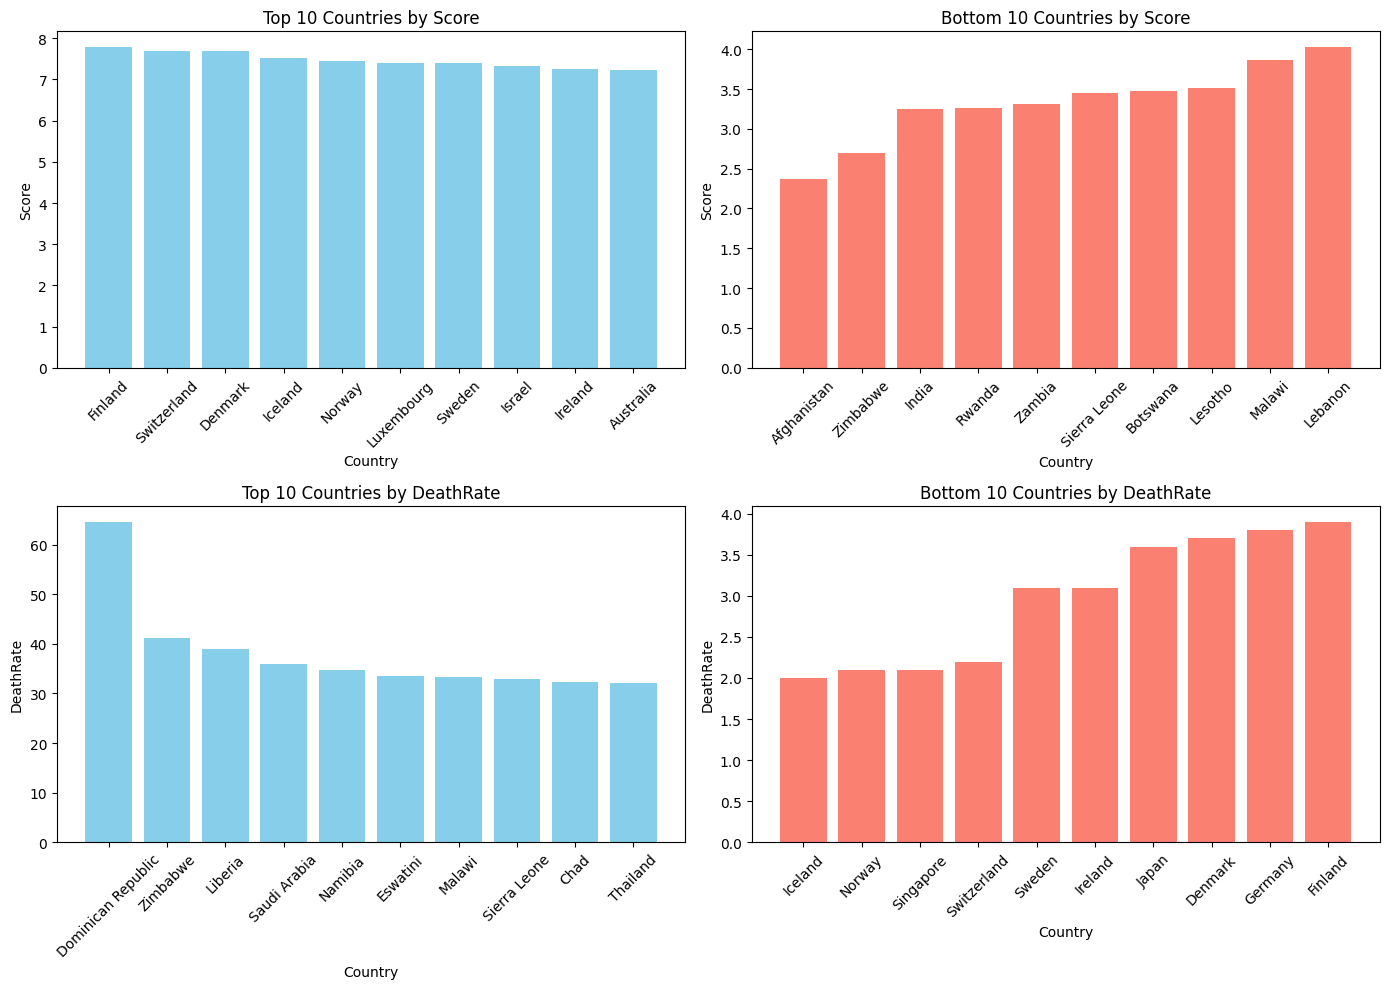

In [45]:

top_10_score = df.nlargest(10, 'Score')[['Country', 'Score']]
bottom_10_score = df.nsmallest(10, 'Score')[['Country', 'Score']]

top_10_death_rate = df.nlargest(10, 'DeathRate')[['Country', 'DeathRate']]
bottom_10_death_rate = df.nsmallest(10, 'DeathRate')[['Country', 'DeathRate']]

# Subplots
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# Plotting top 10 countries by Score
axs[0, 0].bar(top_10_score['Country'], top_10_score['Score'], color='skyblue')
axs[0, 0].set_title('Top 10 Countries by Score')
axs[0, 0].set_xlabel('Country')
axs[0, 0].set_ylabel('Score')
axs[0, 0].tick_params(axis='x', rotation=45)

# Plotting bottom 10 countries by Score
axs[0, 1].bar(bottom_10_score['Country'], bottom_10_score['Score'], color='salmon')
axs[0, 1].set_title('Bottom 10 Countries by Score')
axs[0, 1].set_xlabel('Country')
axs[0, 1].set_ylabel('Score')
axs[0, 1].tick_params(axis='x', rotation=45)

# Plotting top 10 countries by DeathRate
axs[1, 0].bar(top_10_death_rate['Country'], top_10_death_rate['DeathRate'], color='skyblue')
axs[1, 0].set_title('Top 10 Countries by DeathRate')
axs[1, 0].set_xlabel('Country')
axs[1, 0].set_ylabel('DeathRate')
axs[1, 0].tick_params(axis='x', rotation=45)

# Plotting bottom 10 countries by DeathRate
axs[1, 1].bar(bottom_10_death_rate['Country'], bottom_10_death_rate['DeathRate'], color='salmon')
axs[1, 1].set_title('Bottom 10 Countries by DeathRate')
axs[1, 1].set_xlabel('Country')
axs[1, 1].set_ylabel('DeathRate')
axs[1, 1].tick_params(axis='x', rotation=45)

# Adjust layout
plt.tight_layout()
plt.show()

The Nordic countries seems to be doing very well, and it's likely that there is a correlation here.

## Correlations

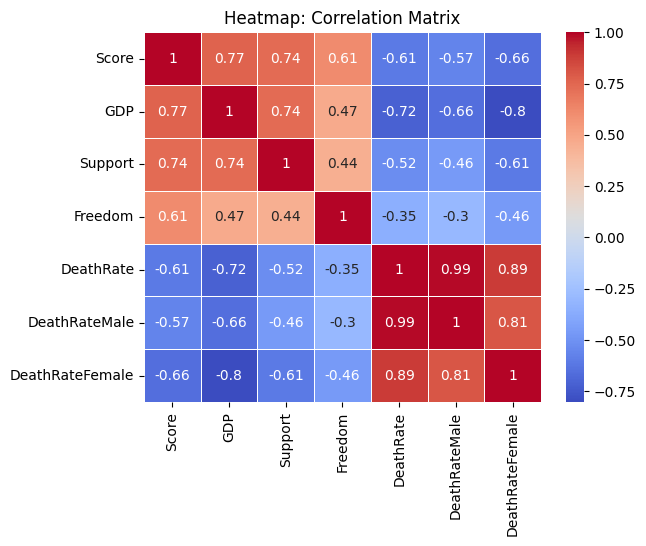

In [46]:
correlation_matrix = df[['Score', 'GDP', 'Support', 'Freedom', 'DeathRate', 'DeathRateMale', 'DeathRateFemale']].corr()

# Heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Heatmap: Correlation Matrix')
plt.show()

The heatmap of the correlation matrix above shows us some very clear indicators. 
- There is a strong correlation (0.77) between Score and GDP, so higher GDP correlates strongly with happiness score.
- There is a moderate positive correlation between Freedom and Score, so higher freedom to make life choices tends to correlate with higher happiness scores. I'm surprised that the correlation isn't higher.
- There are clear negative correlations between deathrates (ranging from -0.35 to 0.72), indicating that high death rates are associated with lower scores in happiness, gdp, support and freedom.

The most important question in this case is if happiness score correlates with the death rate in traffic, and it clearly does. The correlation coefficient is -0.61, so I'd say its a moderate negative correlation. Countries with higherh appiness scores tend to have overall lower death rates, and vice versa. 

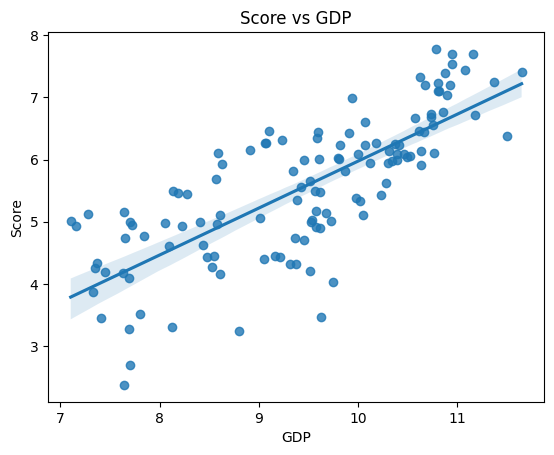

In [47]:
sns.regplot(x='GDP', y='Score', data=df)
plt.title('Score vs GDP')
plt.xlabel('GDP')
plt.ylabel('Score')
plt.show()

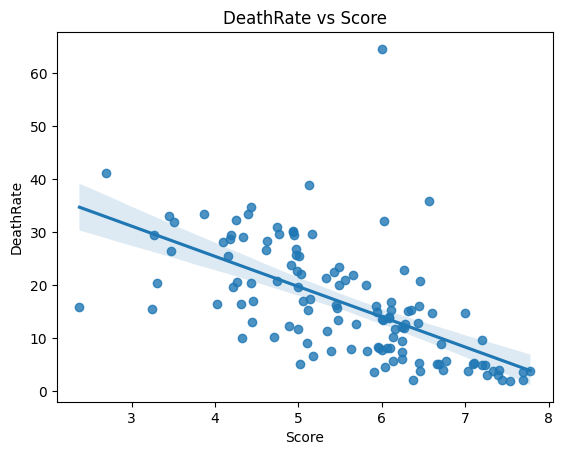

In [48]:
sns.regplot(x='Score', y='DeathRate', data=df)
plt.title('DeathRate vs Score')
plt.xlabel('Score')
plt.ylabel('DeathRate')
plt.show()

When comparing the death rate to the happiness score, we have some very clear outliers. There is one country in particular that sticks out, with a death rate above 60 per 100.000 people. but still has a happiness score well above the mean (0.55). Thre is also one country that scores extremely low on happiness (but has a fairly low death rate in traffic. 

To figure out what countries these are, we can use SciPy. 

In [49]:
# Calculate Z-score for DeathRate
z_scores = stats.zscore(df['DeathRate'])
threshold = 3
df['Country'][np.abs(z_scores) > threshold]

50    Dominican Republic
Name: Country, dtype: object

In [50]:
df[df['Country'] == 'Dominican Republic']

,Country,Year,Score,GDP,Support,Freedom,DeathRate,DeathRateMale,DeathRateFemale
50,Dominican Republic,2019,6.004,9.808,0.884,0.877,64.6,110.6,18.7


Dominican republic is our huge outlier when comparing the deathrate to the happiness score. The death rate stands at 64.6, which on it's own is extremely high, considering the mean is 16.5. However, the death rate for males are 110.6. 

We also have one country that stands out in the opposite direction. It has a fairly low death rate (<20), but also a very low happiness score (<3).

In [51]:
df[(df['Score'] < 3) & (df['DeathRate'] < 20)]['Country']

123    Afghanistan
Name: Country, dtype: object

In [52]:
df[df['Country'] == 'Afghanistan']

,Country,Year,Score,GDP,Support,Freedom,DeathRate,DeathRateMale,DeathRateFemale
123,Afghanistan,2019,2.375,7.64,0.42,0.394,15.9,24.8,6.4


Things are not looking good in Afghanistan... 

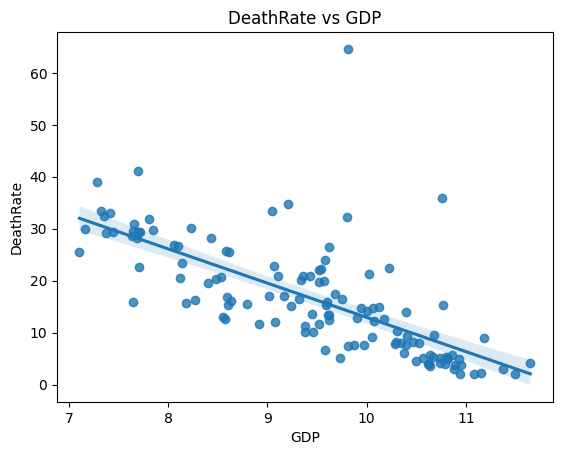

In [53]:
sns.regplot(x='GDP', y='DeathRate', data=df)
plt.title('DeathRate vs GDP')
plt.xlabel('GDP')
plt.ylabel('DeathRate')
plt.show()

There seems to be a heavy correlation between happiness score and GDP, and also a clear correlation between the death rate in traffic with both GDP and happiness score. 

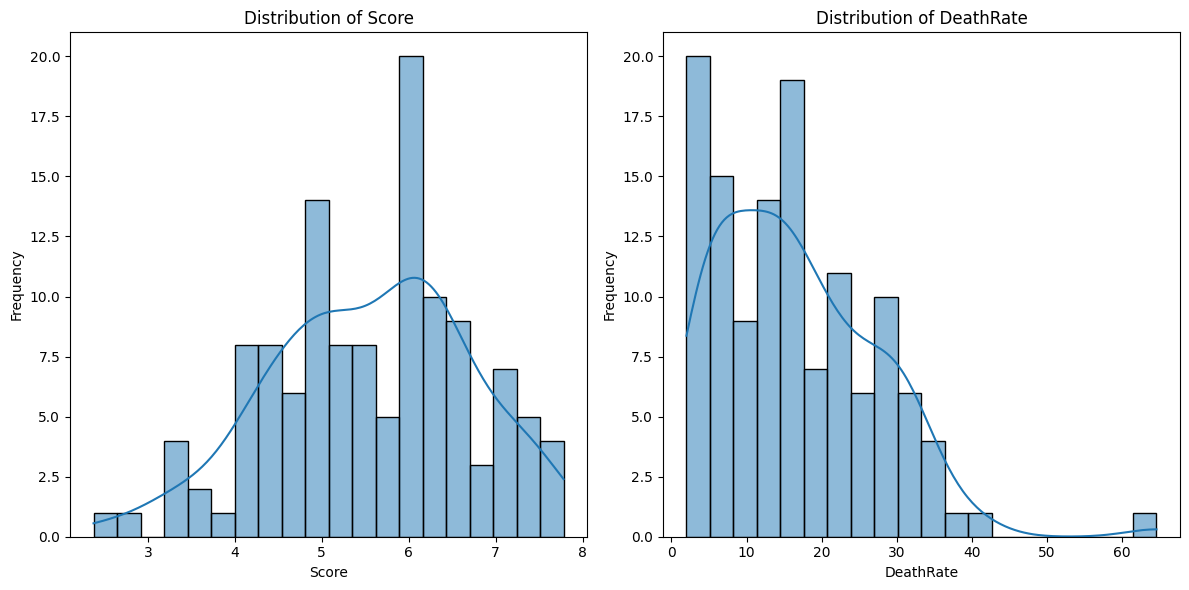

In [54]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Score distribution
sns.histplot(df['Score'], bins=20, kde=True, ax=axs[0])
axs[0].set_title('Distribution of Score')
axs[0].set_xlabel('Score')
axs[0].set_ylabel('Frequency')

# DeathRate distribution
sns.histplot(df['DeathRate'], bins=20, kde=True, ax=axs[1])
axs[1].set_title('Distribution of DeathRate')
axs[1].set_xlabel('DeathRate')
axs[1].set_ylabel('Frequency')

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

#### Male VS Female

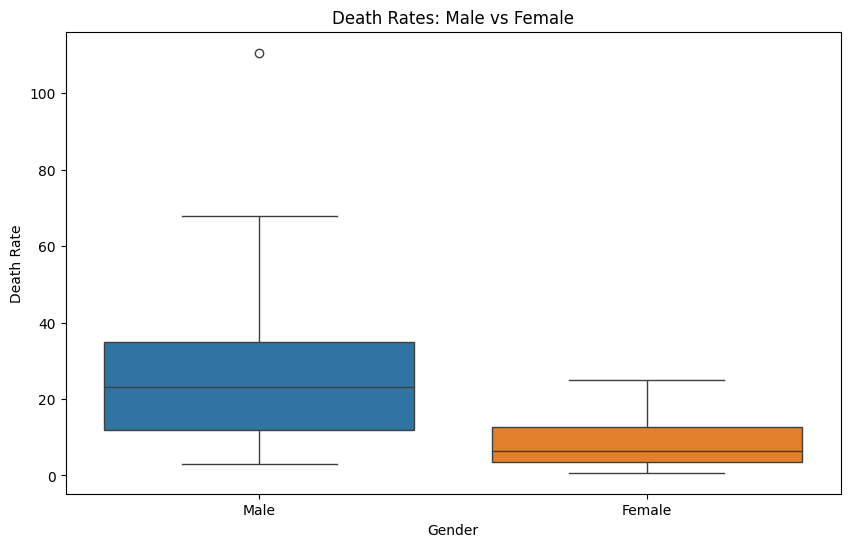

In [55]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df[['DeathRateMale', 'DeathRateFemale']])
plt.title('Death Rates: Male vs Female')
plt.xlabel('Gender')
plt.ylabel('Death Rate')
plt.xticks(ticks=[0, 1], labels=['Male', 'Female'])
plt.show()

### Regression Analysis

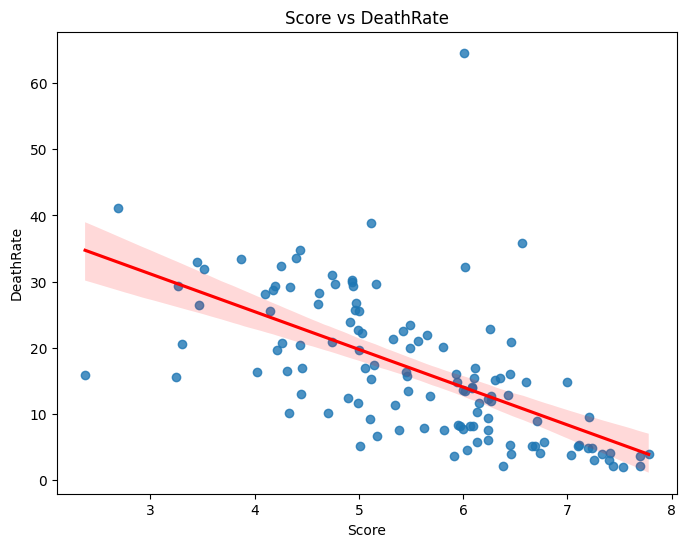

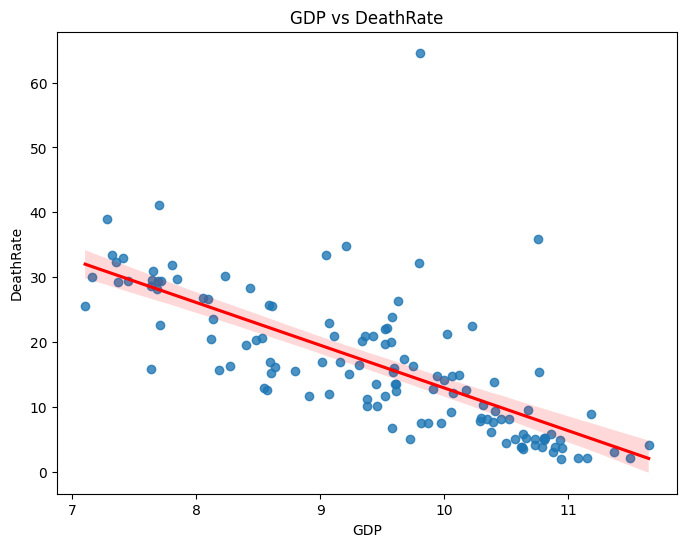

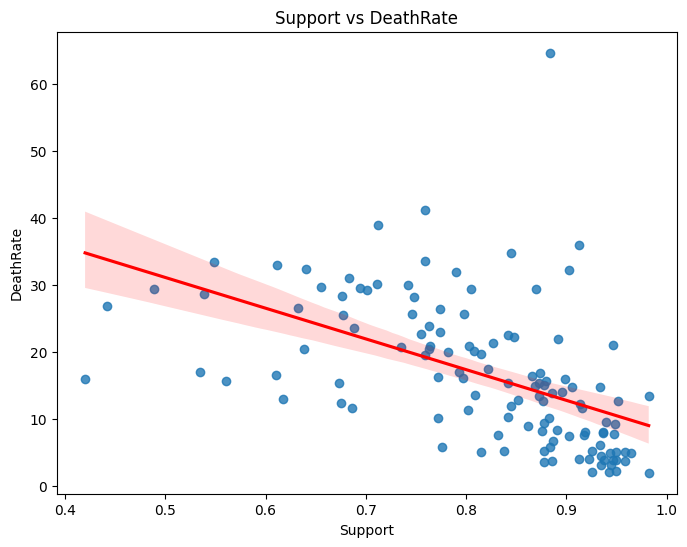

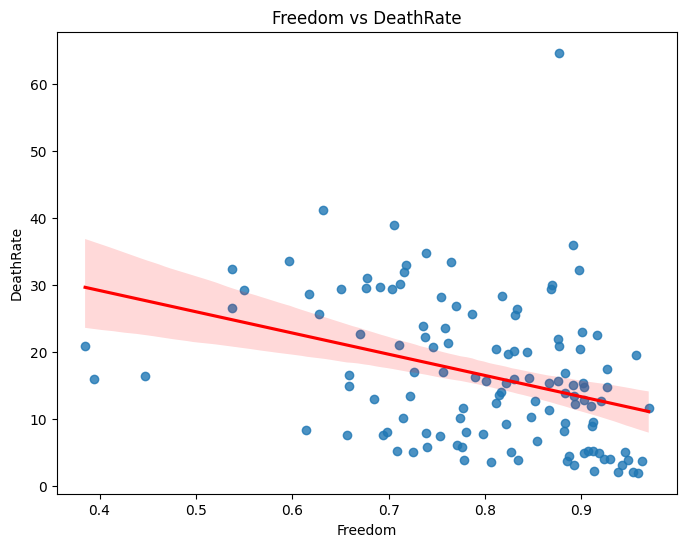

In [56]:
independent_vars = ['Score', 'GDP', 'Support', 'Freedom']

for var in independent_vars:
    X = df[var]
    y = df['DeathRate']
    
    # Constant
    X = sm.add_constant(X)
    
    # Fit the regression model
    model = sm.OLS(y, X).fit()
    
    # Plot
    plt.figure(figsize=(8, 6))
    sns.regplot(x=var, y='DeathRate', data=df, line_kws={'color': 'red'})
    plt.title(f'{var} vs DeathRate')
    plt.xlabel(var)
    plt.ylabel('DeathRate')
    plt.show()


In [58]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              DeathRate   R-squared:                       0.525
Model:                            OLS   Adj. R-squared:                  0.509
Method:                 Least Squares   F-statistic:                     32.85
Date:                Wed, 03 Jul 2024   Prob (F-statistic):           1.92e-18
Time:                        15:56:45   Log-Likelihood:                -423.12
No. Observations:                 124   AIC:                             856.2
Df Residuals:                     119   BIC:                             870.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         74.0999      6.713     11.039      0.000      60.808      87.392
Score         -1.9362      1.098     -1.763      0.080      -4.111       0.239
GDP           -5.8551      0.988     -5.923      0.000      -7.812      -3.898
Support        7.6256      8.966      0.850      0.397     -10.128      25.380
Freedom        2.9161      7.167      0.407      0.685     -11.276      17.108
==============================================================================
Omnibus:                      115.245   Durbin-Watson:                   2.328
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1755.429
Skew:                           3.104   Prob(JB):                         0.00
Kurtosis:                      20.355   Cond. No.                         155.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

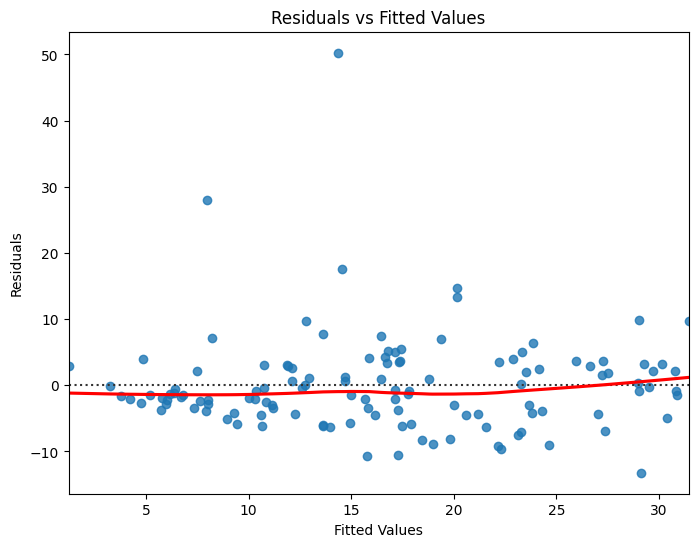

In [60]:
# Independent variables
X = df[['Score', 'GDP', 'Support', 'Freedom']]
y = df['DeathRate']

X = sm.add_constant(X)

# Fit the regression model
model_2 = sm.OLS(y, X).fit()


# Plotting
plt.figure(figsize=(8, 6))
sns.residplot(x=model.fittedvalues, y=model_2.resid, lowess=True, line_kws={'color': 'red'})
plt.title('Residuals vs Fitted Values')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.show()


In [62]:
model_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              DeathRate   R-squared:                       0.525
Model:                            OLS   Adj. R-squared:                  0.509
Method:                 Least Squares   F-statistic:                     32.85
Date:                Wed, 03 Jul 2024   Prob (F-statistic):           1.92e-18
Time:                        15:58:20   Log-Likelihood:                -423.12
No. Observations:                 124   AIC:                             856.2
Df Residuals:                     119   BIC:                             870.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         74.0999      6.713     11.039      0.000      60.808      87.392
Score         -1.9362      1.098     -1.763      0.080      -4.111       0.239
GDP           -5.8551      0.988     -5.923      0.000      -7.812      -3.898
Support        7.6256      8.966      0.850      0.397     -10.128      25.380
Freedom        2.9161      7.167      0.407      0.685     -11.276      17.108
==============================================================================
Omnibus:                      115.245   Durbin-Watson:                   2.328
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1755.429
Skew:                           3.104   Prob(JB):                         0.00
Kurtosis:                      20.355   Cond. No.                         155.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Summary of Findings

1. **Model Fit**:
    - The model explains approximately 52.5% of the variance in traffic mortality rates (`R-squared = 0.525`).
    - The adjusted R-squared value of 0.509 indicates a moderate fit, considering the number of predictors in the model.

2. **Significant Predictor**:
    - **GDP**: The regression results show that GDP has a significant negative relationship with traffic mortality rates (`coef = -5.8551, p < 0.001`). This suggests that higher GDP is associated with lower traffic mortality rates, holding other factors constant.

3. **Non-significant Predictors**:
    - **Happiness Score**: While the coefficient for the happiness score (`coef = -1.9362`) indicates a negative relationship with traffic mortality, the p-value (`p = 0.080`) suggests this relationship is not statistically significant at the 5% level.
    - **Social Support**: The coefficient for social support (`coef = 7.6256`) indicates a positive relationship with traffic mortality, but this is not statistically significant (`p = 0.397`).
    - **Freedom to Make Life Choices**: Similarly, the coefficient for freedom (`coef = 2.9161`) indicates a positive relationship with traffic mortality, but this is not statistically significant (`p = 0.685`).

4. **Residual Analysis**:
    - The residuals exhibit non-normality, as indicated by the significant Omnibus and Jarque-Bera tests (`p < 0.001`), and high skewness (3.104) and kurtosis (20.355). This suggests that the residuals are highly skewed and have heavy tails.
    - The Durbin-Watson statistic (2.328) suggests no significant autocorrelation in the residuals.

Overall, while GDP is a strong and significant predictor of traffic mortality rates, other factors such as happiness score, social support, and freedom to make life choices do not show statistically significant relationships with traffic mortality in this model. The non-normality of residuals suggests that further investigation or different modeling techniques might be needed to fully understand the dynamics at play.
